In [1]:
import tensorflow as tf
import os
import requests
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
import math
import matplotlib.pyplot as plt

In [2]:
##No es necesario volver a ejecutar

url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
local_path = r"C:\Users\CONSULTORIA\SIC\Curso\proyecto_final\Proyecto_Final\weights\inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Crear el directorio si no existe
os.makedirs(os.path.dirname(local_path), exist_ok=True)

response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(local_path, 'wb') as f:
        for chunk in response.iter_content(1024):
            f.write(chunk)
    print("File downloaded successfully")
else:
    print(f"Error downloading file: {response.status_code}")

File downloaded successfully


In [3]:
train_path = r'C:\Users\CONSULTORIA\SIC\Curso\proyecto_final\Proyecto_Final\Dataset\train'
test_path  = r'C:\Users\CONSULTORIA\SIC\Curso\proyecto_final\Proyecto_Final\Dataset\test'

In [4]:
batch_size = 128
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
def create_repeating_generator(generator):
    while True:
        for batch in generator:
            yield batch


train_generator = train_datagen.flow_from_directory(train_path, target_size=(300,300), batch_size=batch_size, class_mode='binary')
val_generator = val_datagen.flow_from_directory(test_path, target_size=(300,300), batch_size=batch_size, class_mode='binary')


Found 9595 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
# Verificar el tamaño de los datos
total_train = len(train_generator.filenames)
total_val = len(val_generator.filenames)

print(f"Total de imágenes de entrenamiento: {total_train}")
print(f"Total de imágenes de validación: {total_val}")

Total de imágenes de entrenamiento: 9595
Total de imágenes de validación: 1000


In [7]:
# Establecer steps_per_epoch y validation_steps en 8
steps_per_epoch = 8
validation_steps = 8

# Comprobaciones adicionales para asegurarse de que hay suficientes datos
if total_train < batch_size * steps_per_epoch:
    print(f"Advertencia: No hay suficientes imágenes de entrenamiento para cubrir {steps_per_epoch} steps con un batch size de {batch_size}.")
if total_val < batch_size * validation_steps:
    print(f"Advertencia: No hay suficientes imágenes de validación para cubrir {validation_steps} steps con un batch size de {batch_size}.")

Advertencia: No hay suficientes imágenes de validación para cubrir 8 steps con un batch size de 128.


In [8]:
local_weights_file = r'C:\Users\CONSULTORIA\SIC\Curso\proyecto_final\Proyecto_Final\weights\inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pretrained_model = InceptionV3(input_shape=(300, 300, 3), include_top=False, weights=None)
pretrained_model.load_weights(local_weights_file)

for layer in pretrained_model.layers:
  layer.trainable=False

In [9]:
last_layer = pretrained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.GlobalAveragePooling2D()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(1, activation='sigmoid')(x)

In [10]:
model = Model(pretrained_model.input, x)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [11]:
history = model.fit(
    create_repeating_generator(train_generator),
    steps_per_epoch=steps_per_epoch,
    epochs=15,
    validation_data=create_repeating_generator(val_generator),
    validation_steps=validation_steps,
    verbose=1
)

Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 172s 21s/step - accuracy: 0.6880 - loss: 0.6051 - val_accuracy: 0.8880 - val_loss: 0.3846
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 142s 19s/step - accuracy: 0.8652 - loss: 0.3777 - val_accuracy: 0.8940 - val_loss: 0.2797
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 140s 19s/step - accuracy: 0.8789 - loss: 0.2991 - val_accuracy: 0.8980 - val_loss: 0.2542
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 146s 20s/step - accuracy: 0.8855 - loss: 0.2909 - val_accuracy: 0.8950 - val_loss: 0.2383
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 152s 20s/step - accuracy: 0.8991 - loss: 0.2601 - val_accuracy: 0.8950 - val_loss: 0.2364
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 145s 19s/step - accuracy: 0.9080 - loss: 0.2405 - val_accuracy: 0.8960 - val_loss: 0.2367
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 143s 19s/step - accuracy: 0.9140 - loss: 0.2322 - val_accuracy: 0.9090 - val_loss: 0.2418
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 142s 19s/step - accuracy: 0.9157 - loss: 0.2191 - val_accuracy: 0.9050 - val_loss:

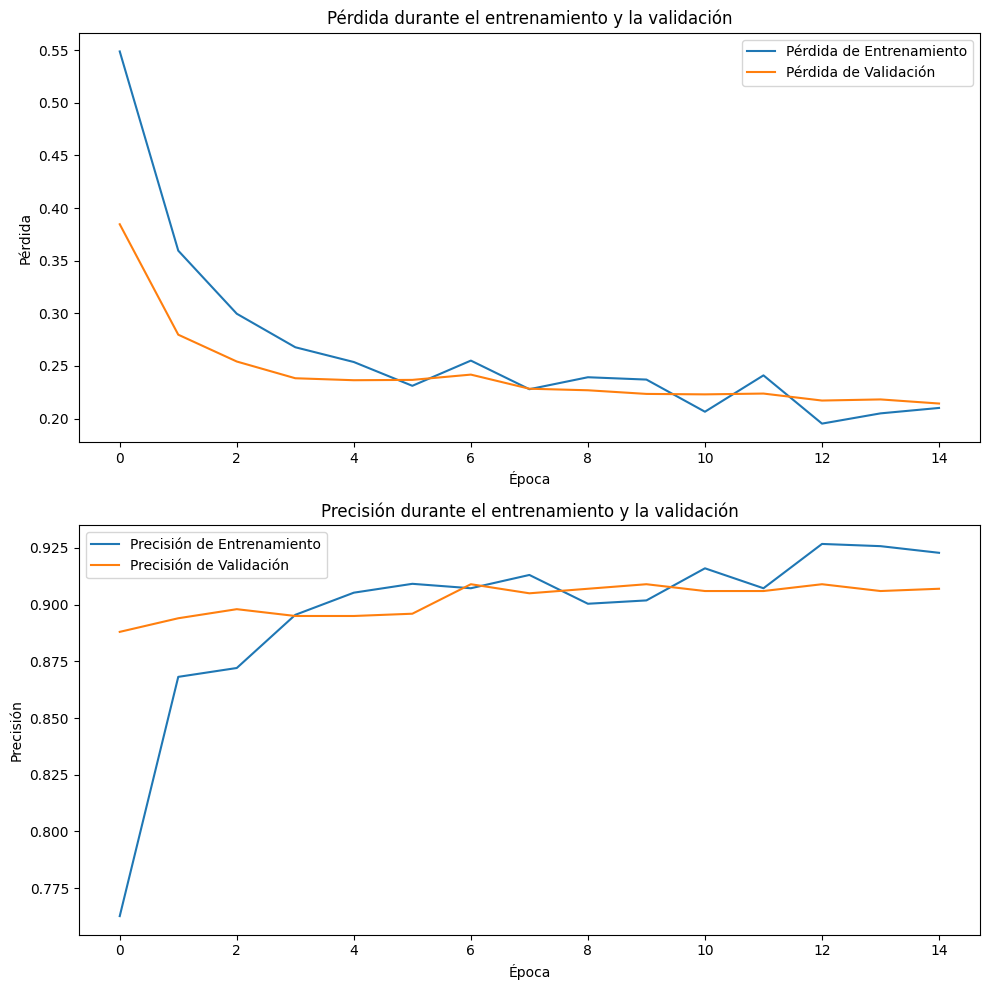

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Graficar la pérdida
ax1.plot(history.history['loss'], label='Pérdida de Entrenamiento')
ax1.plot(history.history['val_loss'], label='Pérdida de Validación')
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida')
ax1.legend()
ax1.set_title('Pérdida durante el entrenamiento y la validación')

# Graficar la precisión
ax2.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
ax2.plot(history.history['val_accuracy'], label='Precisión de Validación')
ax2.set_xlabel('Época')
ax2.set_ylabel('Precisión')
ax2.legend()
ax2.set_title('Precisión durante el entrenamiento y la validación')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

In [19]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_images_in_folder(folder_path, model):
    # Obtener una lista de todos los archivos en la carpeta
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    # Iterar sobre cada archivo de imagen en la carpeta
    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        
        # Cargar y preprocesar la imagen
        img = image.load_img(img_path, target_size=(300, 300))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Reescalar como en el generador de datos
        
        # Realizar la predicción
        prediction = model.predict(img_array)
        
        # Convertir la predicción a una clase binaria
        if prediction[0] > 0.5:
            result = "Maligno"
        else:
            result = "Benigno"
        
        print(f"La imagen {img_file} es predicha como: {result}")

# Ruta de la carpeta con las imágenes a predecir
folder_path = r'C:\Users\CONSULTORIA\SIC\Curso\proyecto_final\Proyecto_Final\Validations\Malignos'

# Realizar la predicción para todas las imágenes en la carpeta
predict_images_in_folder(folder_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
La imagen melanoma_9600.jpg es predicha como: Maligno
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
La imagen melanoma_9601.jpg es predicha como: Maligno
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
La imagen melanoma_9602.jpg es predicha como: Maligno
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
La imagen melanoma_9603.jpg es predicha como: Maligno
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
La imagen melanoma_9604.jpg es predicha como: Maligno


In [17]:
model.save('melanoma_classifier_v2.keras')